In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
import os, sys

In [ ]:
root_file = "../../data/MuGun_Displaced_v250409_Dumper_l1omtf_001.root"

mu_vars = ['muonQOverPt',"muonQPt"]
st_vars =  ['stubEtaG', 'stubPhiG','stubR', 'stubLayer','stubType']
in_vars =  ['inputStubEtaG', 'inputStubPhiG','inputStubR', 'inputStubLayer','inputStubType']

sys.path.append(os.path.join(os.getcwd(), '..', 'tools/training'))

from converter import *

[{eventNum: 45002, muonEvent: -2, muonPt: 3.81, muonEta: 0.297, ...}, ...]


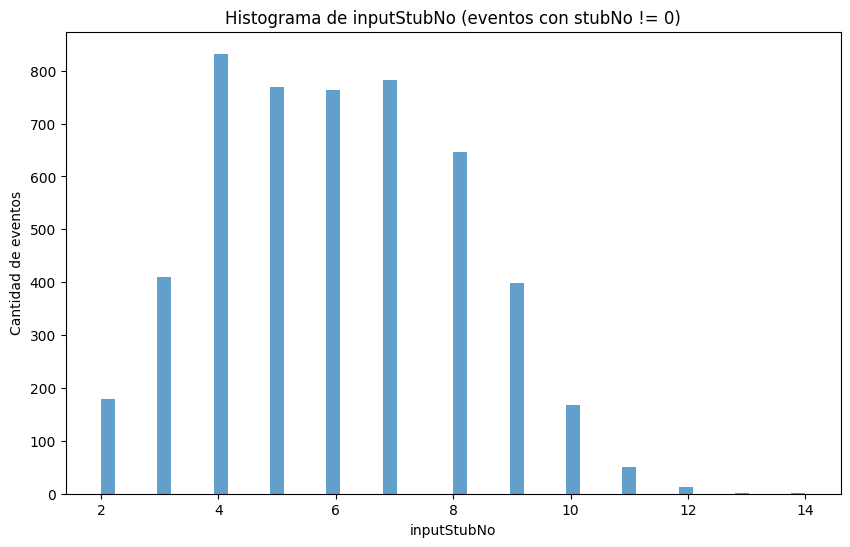

In [3]:
import uproot
import awkward as ak
import matplotlib.pyplot as plt

file = uproot.open(root_file)
tree = file["simOmtfPhase2Digis/OMTFHitsTree"]
arr = tree.arrays(library="ak")

print(arr)
## Plot the inptuStubNo when stubNo is not 0
filtered = arr[arr.stubNo != 0]

# Verificar si la columna 'inputStubNo' existe
if hasattr(filtered, "inputStubNo"):
    # Convertir a numpy para poder graficar
    values = ak.to_numpy(filtered.inputStubNo)
    plt.figure(figsize=(10,6))
    plt.hist(values, bins=50, alpha=0.7)
    plt.xlabel("inputStubNo")
    plt.ylabel("Cantidad de eventos")
    plt.title("Histograma de inputStubNo (eventos con stubNo != 0)")
    plt.show()
else:
    print("La columna 'inputStubNo' no se encontró en el Awkward Array.")


In [4]:
# incorporate new variables: 
arr['stubEtaG'] = arr['stubEta'] * HW_ETA_TO_ETA_FACTOR
arr['stubPhiG'] = get_global_phi(arr['stubPhi'], arr['omtfProcessor'])  ## need to check this value!! (not sure it is OK)


arr['inputStubEtaG'] = arr['inputStubEta'] * HW_ETA_TO_ETA_FACTOR
arr['inputStubPhiG'] = get_global_phi(arr['inputStubPhi'], arr['omtfProcessor'])  ## need to check this value!! (not sure it is OK)

arr['muonQPt'] = arr['muonCharge'] * arr['muonPt']
arr['muonQOverPt'] = arr['muonCharge'] / arr['muonPt']

c:\Users\folguerassantiago\cernbox\L1T\INTREPID\emeleTrigger\pyenv_win\Lib\site-packages\awkward\_nplikes\array_module.py:62: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 192 to int8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  return self._module.asarray(obj, dtype=dtype)
c:\Users\folguerassantiago\cernbox\L1T\INTREPID\emeleTrigger\pyenv_win\Lib\site-packages\awkward\_nplikes\array_module.py:245: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


In [ ]:
from torch_geometric.data import Data

events_processed = 0
data_stub_list = []
data_input_list = []

def getDeltaPhi(phi1,phi2):
    dphi = phi1 - phi2
    dphi = (dphi + torch.pi) % (2 * torch.pi) - torch.pi
    return dphi

def getDeltaEta(eta1,eta2):
    return eta1-eta2


## Now loop over the events and create the dataset: 
for event in ak.to_list(arr):
    if events_processed % 1000 == 0:
        print(f"Processed {events_processed} events")

    ## skip the event with no stubs or inputStubs: 
    if (event['stubNo']) == 0 or (event['inputStubNo']) == 0:
        continue

    node_features = torch.tensor([event[st] for st in st_vars], dtype=torch.float32).T

    ## CREATE THE EDGES: 
    edge_index = []
    edge_attr = []
    for stub1Id,stub1Layer in enumerate(event['stubLayer']):
        for stub2Id, stub2Layer in enumerate(event['stubLayer']):
            if stub1Layer == stub2Layer: continue
            if stub2Layer in getEdgesFromLogicLayer(stub1Layer):
                dphi = getDeltaPhi(event['stubPhiG'][stub1Id],event['stubPhiG'][stub2Id])
                deta = getDeltaEta(event['stubEtaG'][stub1Id],event['stubEtaG'][stub2Id])
                edge_index.append([stub1Id, stub2Id])
                edge_attr.append([dphi, deta])
    
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    
    data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr, y=torch.tensor([event[var] for var in mu_vars], dtype=torch.float))
    data_stub_list.append(data)

    # Now create the input stubs:
    node_features = torch.tensor([event[in_var] for in_var in in_vars], dtype=torch.float32).T
    edge_index = []
    edge_attr = []

    for stub1Id,stub1Layer in enumerate(event['inputStubLayer']):
        for stub2Id, stub2Layer in enumerate(event['inputStubLayer']):
            if stub1Layer == stub2Layer: continue
            if stub2Layer in getEdgesFromLogicLayer(stub1Layer):
                dphi = getDeltaPhi(event['inputStubPhiG'][stub1Id],event['inputStubPhiG'][stub2Id])
                deta = getDeltaEta(event['inputStubEtaG'][stub1Id],event['inputStubEtaG'][stub2Id])
                edge_index.append([stub1Id, stub2Id])
                edge_attr.append([dphi, deta])
    
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr, y=torch.tensor([event[var] for var in mu_vars], dtype=torch.float))

    data_input_list.append(data)

    events_processed += 1

Processed 0 events
Processed 0 events
Processed 1000 events
Processed 1000 events
Processed 1000 events
Processed 1000 events
Processed 1000 events
Processed 2000 events
Processed 3000 events
Processed 4000 events
Processed 5000 events


In [ ]:
#compare two datasets: 
print("Number of stubs: ", len(data_stub_list))
print("Number of input stubs: ", len(data_input_list))
print("Number of stubs in first event: ", len(data_stub_list[0].x))
print("Number of input stubs in first event: ", len(data_input_list[0].x))
print("Number of edges in first event: ", data_stub_list[0].edge_index.shape[1])
print("Number of edges in first event: ", data_input_list[0].edge_index.shape[1])


Number of stubs:  5017
Number of input stubs:  5017
Number of stubs in first event:  5
Number of input stubs in first event:  6
Number of edges in first event:  8
Number of edges in first event:  12
